In [1]:
import random
from typing import Literal

from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from loguru import logger
from pydantic import BaseModel, Field, ValidationError

# Conditional Graph 🚧

## Objetivos:

1.  Implementar lógica **condicional** para rotear o fluxo de dados para diferentes nós.
2.  Usar os nós **START** e **END** para gerenciar explicitamente os pontos de entrada e saída.
3.  Projetar múltiplos nós para realizar operações diferentes (**adição**, **subtração**).
4.  Criar um **nó roteador** (`router node`) para lidar com a tomada de decisão e controlar o fluxo do grafo.

## Objetivo Principal:

Aprender a usar a função `add_conditional_edges()` para criar ramificações no fluxo.

### Definir o `Estado.`
___

### Definir um simples logger com a biblioteca Loguru

In [2]:
# Configuração básica do logger (apenas console)
logger.remove()  # remove configuração padrão
logger.add(lambda msg: print(msg, end=""))  # imprime no notebook sem duplicar

1

In [3]:
class GraphState(BaseModel):
    """Define o estado do grafo para gerar e operar sobre uma lista de inteiros.

    Atributos:
        list_size (int): O tamanho da lista de inteiros a ser gerada.
        min_value (int): O valor mínimo para os números aleatórios.
        max_value (int): O valor máximo para os números aleatórios.
        operation (Literal["sum", "subtraction"]): A operação a ser executada na lista.
        list_data (List[int]): A lista de inteiros gerada.
        result (float): O resultado da operação na lista.
    """

    # Inputs para o nó de geração da lista
    list_size: int = Field(
        default=15, description="O número de elementos a serem gerados na lista."
    )
    min_value: int = Field(
        default=0, description="O valor mínimo para os números aleatórios."
    )
    max_value: int = Field(
        default=100, description="O valor máximo para os números aleatórios."
    )

    # Campo para a operação a ser executada na lista
    operation: Literal["sum", "subtraction"] = Field(
        description="A operação a ser executada na lista: 'sum' ou 'subtraction'."
    )

    # Campos que serão populados durante a execução do grafo
    list_data: list[int] = Field(  # type: ignore  # noqa: PGH003
        default_factory=list, description="A lista de inteiros gerada aleatoriamente."
    )
    result: float = Field(
        default=0.0, description="O resultado da operação executada na lista."
    )

In [4]:
def node_random_create_integer_list(state: "GraphState") -> dict[str, list[int]]:
    """Gera uma lista de inteiros aleatórios com base nos parâmetros do estado.

    Este nó lê os atributos 'list_size', 'min_value', e 'max_value' do estado,
    cria uma lista de inteiros aleatórios e a armazena no atributo 'list_data'
    do estado.

    Args:
        state (GraphState): O estado atual do grafo.

    Returns:
        dict: Um dicionário contendo a lista gerada para atualizar o campo
    'list_data' do estado.

    """
    list_size = state.list_size
    min_val = state.min_value
    max_val = state.max_value

    logger.info(
        f"-> Executando node_generator: criando lista de {list_size} "
        f"inteiros entre {min_val} e {max_val}."
    )

    # Usa list comprehension e random.randint para gerar a lista de forma concisa
    generated_list = [random.randint(min_val, max_val) for _ in range(list_size)]  # noqa: S311

    logger.debug(f"Lista gerada: {generated_list}")
    logger.success("Lista de inteiros aleatórios criada com sucesso!")

    # Retorna o dicionário para que o LangGraph atualize o estado
    return {"list_data": generated_list}

In [5]:
def node_add_element(state: "GraphState") -> dict[str, list[int]]:
    """Adiciona um elemento inteiro à lista no estado.

    Args:
        state (GraphState): O estado atual do grafo. Deve conter os atributos:
            - list_data (list[int]): A lista de inteiros existente.
            - element (int): O elemento a ser adicionado.

    Returns:
        dict[str, list[int]]: Um dicionário contendo a lista atualizada sob a chave
        "list_data".

    """
    element: int = state.element  # type: ignore # noqa: PGH003

    # Log para informar que o nó começou a ser executado
    logger.info("-> Executando node_add_element para adicionar o elemento: %s", element)

    # Log de depuração para ver o estado ANTES da mudança
    logger.debug("Lista ANTES da adição: %s", state.list_data)

    # Lógica principal: cria nova lista com o elemento adicionado
    if element is None:
        logger.error("O elemento fornecido é None e não pode ser adicionado à lista.")
        updated_list = state.list_data.copy()
    else:
        try:
            updated_list = [*state.list_data, int(element)]
        except (TypeError, ValueError) as e:
            logger.error(f"Erro ao converter o elemento para int: {e}")
            updated_list = state.list_data.copy()

    # Log de depuração para ver o estado DEPOIS da mudança
    logger.debug("Lista DEPOIS da adição: %s", updated_list)

    # Log de sucesso (info usado em vez de success por compatibilidade)
    logger.info("Elemento adicionado com sucesso!")

    # Retorno no formato esperado pelo LangGraph
    return {"list_data": updated_list}

In [6]:
def sum_node(state: "GraphState") -> dict[str, float]:
    """Calcula a soma de todos os elementos na lista de dados do estado.

    Este nó lê a lista de inteiros do atributo 'list_data' do estado,
    utiliza a função nativa sum() para calcular o total e atualiza o
    atributo 'result' do estado com o valor calculado.

    Args:
        state (GraphState): O estado atual do grafo, contendo a 'list_data'.

    Returns:
        dict[str, float]: Um dicionário para que o LangGraph atualize o campo 'result'
        do estado com a soma calculada.

    """
    logger.info("-> Executando sum_node para calcular a soma da lista.")

    # 1. Acessa a lista original gerada a partir do estado.
    list_to_sum = state.list_data
    logger.debug(f"Lista de entrada para a soma: {list_to_sum}")

    # 2. Usa a função sum() para somar os elementos.
    total_sum = sum(list_to_sum)
    logger.debug(f"Resultado da soma: {total_sum}")

    logger.success("Soma calculada com sucesso!")

    # 3. Retorna o novo estado (apenas o campo que foi alterado).
    #    A lista de entrada ('list_data') já está no estado, então não
    #    precisamos retorná-la, apenas o novo resultado.
    return {"result": total_sum}

In [7]:
def node_subtract_element(state: "GraphState") -> dict[str, list[int]]:
    """Remove um elemento inteiro da lista no estado.

    Args:
        state (GraphState): O estado atual do grafo. Deve conter os atributos:
            - list_data (list[int]): A lista de inteiros existente.
            - element (int): O elemento a ser removido.

    Returns:
        dict[str, list[int]]: Um dicionário contendo a lista atualizada sob a chave
        "list_data".

    """
    element: int = state.element  # type: ignore # noqa: PGH003

    # Log para informar que o nó começou a ser executado
    logger.info(
        "-> Executando node_subtract_element para remover o elemento: %s", element
    )

    # Log de depuração para ver o estado ANTES da mudança
    logger.debug("Lista ANTES da remoção: %s", state.list_data)

    # Lógica principal: cria nova lista sem o elemento removido
    updated_list = state.list_data.remove(element)

    # Log de depuração para ver o estado DEPOIS da mudança
    logger.debug("Lista DEPOIS da remoção: %s", updated_list)

    # Log de sucesso (info usado em vez de success por compatibilidade)
    logger.info("Elemento removido com sucesso!")

    # Retorno no formato esperado pelo LangGraph
    return {"list_data": updated_list}

In [8]:
# * Supondo que a classe GraphState já foi definida
# from typing import Literal
# from langchain_core.pydantic_v1 import BaseModel, Field
# class GraphState(BaseModel):
#     number1: float
#     number2: float
#     operation: Literal["addition", "subtraction"]
#     result: float = 0.0

In [9]:
def subtraction_node(state: "GraphState") -> dict[str, float]:
    """Calcula a diferença entre o maior e o menor elemento da lista.

    Este nó lê a lista de inteiros do atributo 'list_data', encontra o
    valor máximo e o valor mínimo, e calcula a diferença entre eles. O
    resultado é armazenado no atributo 'result' do estado.

    Args:
        state (GraphState): O estado atual do grafo, contendo a 'list_data'.

    Returns:
        dict: Um dicionário para que o LangGraph atualize o campo 'result'
    do estado com a diferença calculada.

    """
    logger.info("-> Executando subtraction_node.")

    list_to_process = state.list_data
    logger.debug(f"Lista de entrada para a subtração: {list_to_process}")

    # Tratamento de caso especial: se a lista for  pequena, a operação não faz sentido.
    if len(list_to_process) < 2:  # noqa: PLR2004
        logger.warning(
            "A lista tem menos de dois elementos, não é possível subtrair.\
            Retornando 0."
        )
        return {"result": 0.0}

    # 1. Usa as funções max() e min() para achar os números.
    max_val = max(list_to_process)
    min_val = min(list_to_process)
    logger.debug(f"Valor máximo encontrado: {max_val}, Valor mínimo: {min_val}")

    # 2. Executa a subtração.
    result = max_val - min_val
    logger.debug(f"Resultado da subtração (max - min): {result}")

    logger.success("Subtração calculada com sucesso!")

    # 3. Retorna o dicionário para que o LangGraph atualize o estado.
    return {"result": result}

In [10]:
def router(state: GraphState) -> str:
    """Determine o próximo nó a ser executado com base na operação no estado.

    Esta função atua como a ramificação condicional do grafo, lendo o
    atributo `operation` do estado para decidir o próximo passo do fluxo.

    Args:
        state (GraphState): O estado atual do grafo. A função inspeciona
            o atributo `state.operation`.

    Returns:
        str: O nome do próximo nó a ser executado, que pode ser
            "sum_node" ou "subtraction_node".

    Raises:
        ValueError: Lançado se o `state.operation` contiver um valor
            que não seja "sum" nem "subtraction".

    """
    logger.info(
        "-> Roteador: decidindo o caminho para a operação '%s'", state.operation
    )

    if state.operation == "sum":
        return "sum_node"
    if state.operation == "subtraction":
        return "subtraction_node"

    # Tratamento explícito de operações inválidas
    logger.error("Operação desconhecida: %s", state.operation)
    raise ValueError(f"Operação desconhecida: {state.operation}")

In [11]:
def build_graph() -> StateGraph:
    """Constrói, conecta e compila o grafo de geração e operação de listas.

    Este grafo segue o fluxo:
    1. Gera uma lista de números aleatórios.
    2. Usa um roteador para decidir qual operação executar (soma ou subtração).
    3. Executa a operação escolhida.
    4. Termina.

    Returns:
        Um grafo LangGraph compilado e pronto para ser executado.

    """
    grafo = StateGraph(GraphState)

    # 1. Adiciona os nós que modificam o estado
    grafo.add_node("random_list_generator", node_random_create_integer_list)
    grafo.add_node("sum_node", sum_node)
    grafo.add_node("subtraction_node", subtraction_node)

    # 2. Define o ponto de entrada do grafo
    grafo.set_entry_point("random_list_generator")

    # 3. Adiciona a aresta condicional
    #    Esta é a parte principal do exercício!
    grafo.add_conditional_edges(
        # A decisão é tomada APÓS a execução deste nó:
        "random_list_generator",
        # A função roteadora é chamada para decidir o caminho:
        router,
        # O mapa de "saída do roteador" -> "nó de destino":
        {
            "sum_node": "sum_node",
            "subtraction_node": "subtraction_node",
        },
    )

    # 4. Adiciona as arestas dos nós de operação para o fim do grafo
    grafo.add_edge("sum_node", END)
    grafo.add_edge("subtraction_node", END)

    # 5. Compila e retorna a aplicação
    logger.success("Grafo construído e compilado com sucesso!")
    return grafo.compile()

In [12]:
graph = build_graph()

2025-09-18 18:10:42.025 | SUCCESS  | __main__:build_graph:43 - Grafo construído e compilado com sucesso!


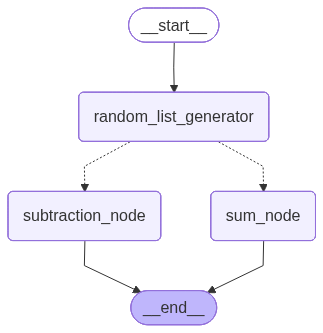

In [13]:
display(
    Image(graph.get_graph().draw_mermaid_png())
)

In [14]:
# --- Célula de Execução ---

# --- Teste 1: Gerar lista e SOMAR ---
print("--- EXECUTANDO TESTE DE SOMA ---")
# O input define a operação e os parâmetros para o gerador
inputs_sum = {"operation": "sum", "list_size": 10, "min_value": 1, "max_value": 50}
final_state_sum = graph.invoke(inputs_sum)

print("\n--- ✅ RESULTADO FINAL (SOMA) ---")
print(f"Lista Gerada..: {final_state_sum['list_data']}")
print(f"Operação......: '{final_state_sum['operation']}'")
print(f"Resultado.....: {final_state_sum['result']}")
print("--------------------------------\n")


# --- Teste 2: Gerar lista e SUBTRAIR (max - min) ---
print("--- EXECUTANDO TESTE DE SUBTRAÇÃO ---")
inputs_sub = {
    "operation": "subtraction",
    "list_size": 8,
    "min_value": 10,
    "max_value": 20,
}
final_state_sub = graph.invoke(inputs_sub)

print("\n--- ✅ RESULTADO FINAL (SUBTRAÇÃO) ---")
print(f"Lista Gerada..: {final_state_sub['list_data']}")
print(f"Operação......: '{final_state_sub['operation']}'")
print(f"Resultado.....: {final_state_sub['result']}")
print("------------------------------------\n")

--- EXECUTANDO TESTE DE SOMA ---
2025-09-18 18:10:42.597 | INFO     | __main__:node_random_create_integer_list:20 - -> Executando node_generator: criando lista de 10 inteiros entre 1 e 50.
2025-09-18 18:10:42.597 | DEBUG    | __main__:node_random_create_integer_list:28 - Lista gerada: [7, 1, 6, 11, 49, 14, 10, 15, 47, 46]
2025-09-18 18:10:42.597 | SUCCESS  | __main__:node_random_create_integer_list:29 - Lista de inteiros aleatórios criada com sucesso!
2025-09-18 18:10:42.597 | INFO     | __main__:router:20 - -> Roteador: decidindo o caminho para a operação '%s'
2025-09-18 18:10:42.597 | INFO     | __main__:sum_node:16 - -> Executando sum_node para calcular a soma da lista.
2025-09-18 18:10:42.597 | DEBUG    | __main__:sum_node:20 - Lista de entrada para a soma: [7, 1, 6, 11, 49, 14, 10, 15, 47, 46]
2025-09-18 18:10:42.597 | DEBUG    | __main__:sum_node:24 - Resultado da soma: 206
2025-09-18 18:10:42.597 | SUCCESS  | __main__:sum_node:26 - Soma calculada com sucesso!

--- ✅ RESULTADO FI

In [15]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text

# Cria uma instância do console do Rich para imprimir saídas formatadas
console = Console()

In [16]:
# --- Célula de Execução Aprimorada ---

# Supondo que a célula que compila o 'app' já foi executada

# --- Teste 1: Gerar lista e SOMAR ---
console.print("\n[bold blue]--- EXECUTANDO TESTE DE SOMA ---[/bold blue]")
inputs_sum = {"operation": "sum", "list_size": 10, "min_value": 1, "max_value": 50}
final_state_sum = graph.invoke(inputs_sum)

# Cria um painel visualmente agradável para o resultado
result_text_sum = Text()
result_text_sum.append("Lista Gerada..: ", style="bold")
result_text_sum.append(f"{final_state_sum['list_data']}\n")
result_text_sum.append("Operação......: ", style="bold")
result_text_sum.append(f"'{final_state_sum['operation']}'\n")
result_text_sum.append("Resultado.....: ", style="bold green")
result_text_sum.append(f"{final_state_sum['result']}", style="bold green")

console.print(
    Panel(
        result_text_sum,
        title="[bold green]✅ RESULTADO FINAL (SOMA)[/bold green]",
        expand=False,
    )
)


# --- Teste 2: Gerar lista e SUBTRAIR (max - min) ---
console.print("\n[bold blue]--- EXECUTANDO TESTE DE SUBTRAÇÃO ---[/bold blue]")
inputs_sub = {
    "operation": "subtraction",
    "list_size": 8,
    "min_value": 10,
    "max_value": 20,
}
final_state_sub = graph.invoke(inputs_sub)

result_text_sub = Text()
result_text_sub.append("Lista Gerada..: ", style="bold")
result_text_sub.append(f"{final_state_sub['list_data']}\n")
result_text_sub.append("Operação......: ", style="bold")
result_text_sub.append(f"'{final_state_sub['operation']}'\n")
result_text_sub.append("Resultado.....: ", style="bold green")
result_text_sub.append(f"{final_state_sub['result']}", style="bold green")

console.print(
    Panel(
        result_text_sub,
        title="[bold green]✅ RESULTADO FINAL (SUBTRAÇÃO)[/bold green]",
        expand=False,
    )
)

--- EXECUTANDO TESTE DE SOMA ---

2025-09-18 18:10:46.439 | INFO     | __main__:node_random_create_integer_list:20 - -> Executando node_generator: criando lista de 10 inteiros entre 1 e 50.
2025-09-18 18:10:46.440 | DEBUG    | __main__:node_random_create_integer_list:28 - Lista gerada: [33, 36, 4, 11, 24, 34, 18, 48, 44, 4]
2025-09-18 18:10:46.440 | SUCCESS  | __main__:node_random_create_integer_list:29 - Lista de inteiros aleatórios criada com sucesso!
2025-09-18 18:10:46.440 | INFO     | __main__:router:20 - -> Roteador: decidindo o caminho para a operação '%s'
2025-09-18 18:10:46.440 | INFO     | __main__:sum_node:16 - -> Executando sum_node para calcular a soma da lista.
2025-09-18 18:10:46.440 | DEBUG    | __main__:sum_node:20 - Lista de entrada para a soma: [33, 36, 4, 11, 24, 34, 18, 48, 44, 4]
2025-09-18 18:10:46.440 | DEBUG    | __main__:sum_node:24 - Resultado da soma: 256
2025-09-18 18:10:46.440 | SUCCESS  | __main__:sum_node:26 - Soma calculada com sucesso!


╭────────────── ✅ RESULTADO FINAL (SOMA) ───────────────╮
│ Lista Gerada..: [33, 36, 4, 11, 24, 34, 18, 48, 44, 4] │
│ Operação......: 'sum'                                  │
│ Resultado.....: 256                                    │
╰────────────────────────────────────────────────────────╯

--- EXECUTANDO TESTE DE SUBTRAÇÃO ---

2025-09-18 18:10:46.444 | INFO     | __main__:node_random_create_integer_list:20 - -> Executando node_generator: criando lista de 8 inteiros entre 10 e 20.
2025-09-18 18:10:46.444 | DEBUG    | __main__:node_random_create_integer_list:28 - Lista gerada: [10, 11, 19, 10, 14, 14, 16, 12]
2025-09-18 18:10:46.444 | SUCCESS  | __main__:node_random_create_integer_list:29 - Lista de inteiros aleatórios criada com sucesso!
2025-09-18 18:10:46.444 | INFO     | __main__:router:20 - -> Roteador: decidindo o caminho para a operação '%s'
2025-09-18 18:10:46.444 | INFO     | __main__:subtraction_node:16 - -> Executando subtraction_node.
2025-09-18 18:10:46.444 | DEBUG    | __main__:subtraction_node:19 - Lista de entrada para a subtração: [10, 11, 19, 10, 14, 14, 16, 12]
2025-09-18 18:10:46.444 | DEBUG    | __main__:subtraction_node:32 - Valor máximo encontrado: 19, Valor mínimo: 10
2025-09-18 18:10:46.444 | DEBUG    | __main__:subtraction_node:36 - Resultado da subtração (max - min): 9
2025-09-18 18:

╭───────── ✅ RESULTADO FINAL (SUBTRAÇÃO) ─────────╮
│ Lista Gerada..: [10, 11, 19, 10, 14, 14, 16, 12] │
│ Operação......: 'subtraction'                    │
│ Resultado.....: 9                                │
╰──────────────────────────────────────────────────╯